In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv

In [2]:
env = CliffWalkingEnv()
action_descriptions = { 0: 'up', 1: 'right', 2: 'down', 3: 'left' }

In [3]:
def policy(state, parameters, biases):
    s = parameters[state] + biases 
    shift = s - np.max(s)
    action_probs = np.exp(shift)
    return action_probs / np.sum(action_probs)

def score_function(state, action, parameters, biases):
    result = -policy(state, parameters, biases)
    result[action] += 1
    return result

In [4]:
class AdamOptimizer:
    def __init__(self, parameters, alpha, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.m = np.zeros_like(parameters)
        self.v = np.zeros_like(parameters)
        self.t = 0
        
    def step(self, gradients):
        self.t += 1
        lrt = self.alpha * np.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t)
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradients**2
        
        self.parameters -= self.alpha * lrt * self.m / (np.sqrt(self.v) + self.epsilon)

In [5]:
def plot_information(plot_v = False):
    policies = np.array([policy(s, parameters, bias) for s in range(env.observation_space.n)])
    fig, axes = plt.subplots(2, 2, figsize=(17, 7))
    for j in range(4):
        axes.flat[j].set_title(f'Action {action_descriptions[j]}')
        image = policies[:, j].reshape((4, -1))
        im = axes.flat[j].imshow(image)
    fig.colorbar(im, ax=axes.ravel().tolist())

    if (plot_v):
        fig = plt.figure(figsize=(17, 4))
        plt.imshow(values.reshape((4, -1)) + value_bias)
        plt.title('State values')
        plt.colorbar()
    plt.show()

In [ ]:
parameters = np.zeros((env.observation_space.n, env.action_space.n), dtype=np.float32)
bias = np.zeros(env.action_space.n, dtype=np.float32)
values = np.zeros(env.observation_space.n, dtype=np.float32)
value_bias = 0

# parameters_optimizers = [AdamOptimizer(parameters[state], 0.01) for state in range(env.observation_space.n)]
# bias_optimizer = AdamOptimizer(biases, 0.01)
# values_optimizers = [AdamOptimizer(values[state], 0.1) for state in range(env.observation_space.n)]
# values_bias_optimizer = AdamOptimizer(value_bias, 0.1)

episode_lengths = []
total_rewards = []

for i in range(4000):
    state = env.reset()
    done = False
    steps = []
    
    while not done:
        action_probs = policy(state, parameters, bias)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        next_state, reward, done, _ = env.step(action)
        steps.append((state, action, reward, next_state))
        state = next_state

    for j in range(len(steps)):
        state, action, reward, _ = steps[j]
        total_reward = sum(steps[k][2] for k in range(j, len(steps)))
        if j == 0:
            total_rewards.append(total_reward)
            
#         if (steps[-1][3] == 47):
#             print(f'Total reward: {total_reward}, parameters: {parameters[state]}, value: {values[state]}, ' +
#                    f'policy: {policy(state, parameters)}, score function: {score_function(state, action, parameters)}')

        parameters_gradient = - score_function(state, action, parameters, bias) * (total_reward - values[state] - value_bias)
        values_gradient = values[state] + value_bias - total_reward
        
        parameters[state] -= 0.01 * parameters_gradient
        bias -= 0.01 * parameters_gradient
        values[state] -= 0.1 * values_gradient
        value_bias -= 0.1 * values_gradient
        
#         if (steps[-1][3] == 47):
#             print(f'Parameters after update: {parameters[state]}, value after update: {values[state]}, policy: {policy(state, parameters)}')
    
#     if (steps[-1][3] == 47):
#         print(f'# Achieved target in iteration {i}! Total reward: {total_rewards[-1]}')
#         print('Plotting information')
#         plot_information(True)
        
    episode_lengths.append(len(steps))
    if i % 500 == 0:
        print(f'Episode {i}: {[action_descriptions[s[1]] for s in steps]}')
        plot_information(True)

In [ ]:
parameters[36]

In [ ]:
biases

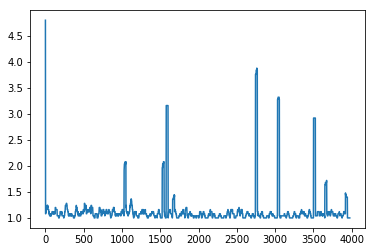

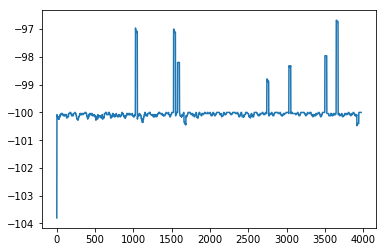

In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(episode_lengths, 25))
plt.figure()
plt.plot(running_mean(total_rewards, 25))

In [ ]:
parameters[36]

In [ ]:
policy(36, parameters)